In [1]:
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import seaborn as sns
from firthlogist import FirthLogisticRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

sys.path.append("../../src")

from datahandler import DataHandler

In [2]:
data_dir = DataHandler.DATA_DIR
feat_df = pd.read_csv(data_dir / "processed_data.csv")

USED_INDEXES = [1, 2, 3]
feat_df = feat_df[feat_df["sex"] == "female"]
feat_df = feat_df[feat_df["number"].isin(USED_INDEXES)]

feature_cols = [
    "AR", "STD_SPEED", "STDP", "VOL_VAR_GLOBAL", "F1F2R_100",
    "AVG_SILENCE_DURATION_SENTENCE",
]

target_col = "is_proficient"

feat_df = feat_df[[*feature_cols, target_col]]

schema = pa.DataFrameSchema({
    "AR": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "STD_SPEED": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "STDP": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "VOL_VAR_GLOBAL": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "F1F2R_100": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "AVG_SILENCE_DURATION_SENTENCE": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "is_proficient": pa.Column(pa.Bool),
})

feat_df = schema.validate(feat_df)

In [3]:
# scaling the features
scaler = StandardScaler()
RAW_X = scaler.fit_transform(feat_df[feature_cols])
RAW_Y = feat_df[target_col]

In [4]:
model_settings = [  # (method_name, model_constructor, model_kwargs)
    (
        "Firth",
        FirthLogisticRegression,
        {"max_iter": 10000, "skip_pvals": True, "skip_ci": True},
    ),
    ("normal", LogisticRegression, {"max_iter": 10000, "penalty": None}),
    (
        "CV_L2",
        LogisticRegressionCV,
        {
            "max_iter": 10000,
            "penalty": "l2",
            "cv": LeaveOneOut(),
            "Cs": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
        },
    ),
]

In [5]:
# firth logistic regression
from firthlogist import FirthLogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feat_df[feature_cols])
X = scaler.transform(feat_df[feature_cols])
y = feat_df[target_col].astype(int).to_numpy()

clf = FirthLogisticRegression()
clf.fit(X, y)
display(pd.Series(dict(zip(feature_cols, clf.coef_.squeeze()))))
display(clf.summary(xname=feature_cols))

AR                               3.077753
STD_SPEED                       -1.534079
STDP                            -0.292574
VOL_VAR_GLOBAL                  -0.330151
F1F2R_100                       -0.414282
AVG_SILENCE_DURATION_SENTENCE   -0.309535
dtype: float64

                                    coef    std err     [0.025       0.975]     p-value
-----------------------------  ---------  ---------  ---------  -----------  ----------
AR                              3.07775    1.56199    0.539425  10.3826      0.00630975
STD_SPEED                      -1.53408    1.21432   -6.66768    0.582551    0.141235
STDP                           -0.292574   1.03821   -4.21446    2.41988     0.710166
VOL_VAR_GLOBAL                 -0.330151   1.09705   -7.3637     2.85665     0.144393
F1F2R_100                      -0.414282   0.900715  -3.35141    1.58688     0.128917
AVG_SILENCE_DURATION_SENTENCE  -0.309535   1.09996   -3.3519     2.60294     0.380499
Intercept                      -2.0778     1.13939   -7.21      -0.00122249  0.0483956

Log-Likelihood: -2.7452
Newton-Raphson iterations: 14



None

In [9]:
def generate_sample(
        n_sample: int,
        intercept: float,
        beta: np.ndarray,
        rng: np.random.Generator,
    ) -> tuple[np.ndarray, np.ndarray]:
    mu = np.zeros(RAW_X.shape[1])
    cov = np.cov(RAW_X.T)
    x = rng.multivariate_normal(mu, cov, n_sample)
    prob = 1 / (1 + np.exp(-(intercept + x @ beta)))
    y = np.random.binomial(1, prob)  # noqa: NPY002
    return x, y

In [10]:
rng = np.random.default_rng(42)
MC = 1000
n_sample = len(feat_df)
n_feature = len(feature_cols)

beta = clf.coef_.squeeze()
intercept = clf.intercept_
display(beta)


def do_one_simulation_for_all_models(rng: np.random.Generator) -> dict[str, np.ndarray]:
    result_dict = {}
    for method_name, model_constructor, model_kwargs in model_settings:
        x, y = generate_sample(n_sample, intercept, beta, rng)
        if np.unique(y).size == 1:
            continue
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        model = model_constructor(**model_kwargs)
        model.fit(x, y)
        result_dict[method_name] = model.coef_.squeeze()
    return result_dict


rng_list = rng.spawn(MC)
results = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(do_one_simulation_for_all_models)(rng) for rng in rng_list
)

method2coefs = {}
for method_name, _, _ in model_settings:
    method2coefs[method_name] = np.array([r[method_name] for r in results]) # type: ignore  # noqa: PGH003

array([ 3.07775299, -1.53407851, -0.29257441, -0.33015064, -0.4142823 ,
       -0.3095352 ])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

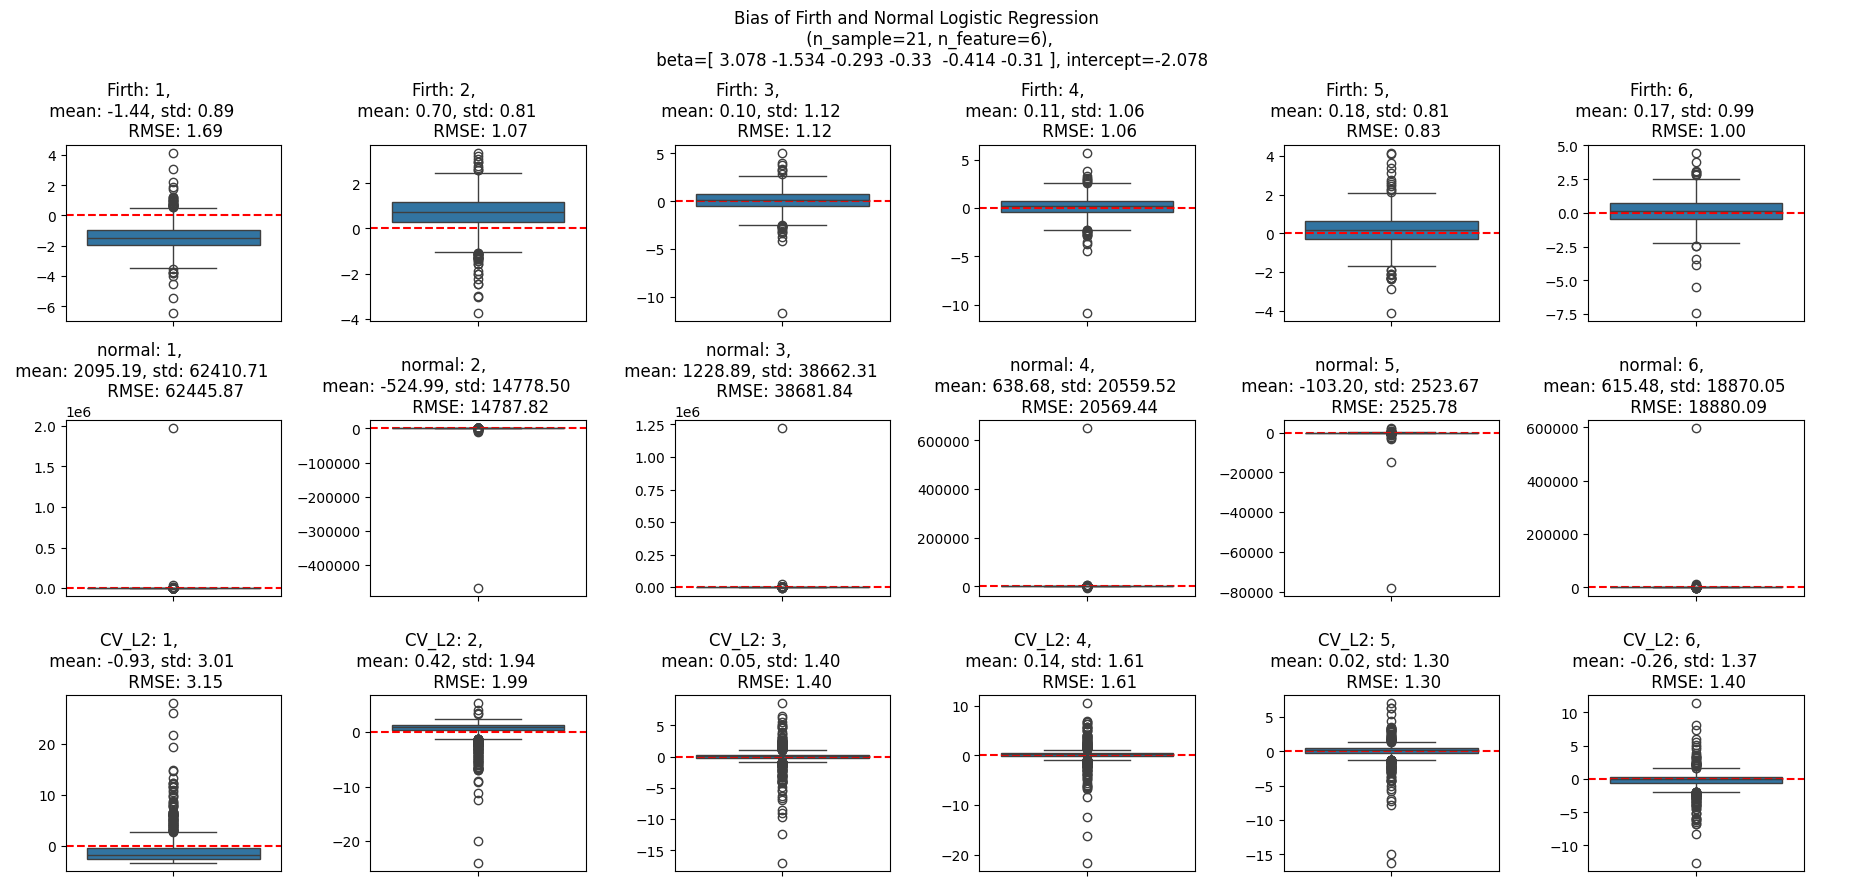

In [11]:
# plot the bias
fig, axs = plt.subplots(
    len(method2coefs), n_feature, figsize=(3 * n_feature, 3 * len(method2coefs))
)
for i, method in enumerate(method2coefs.keys()):
    bias = method2coefs[method] - beta
    for j in range(n_feature):
        sns.boxplot(bias[:, j], ax=axs[i, j])
        axs[i, j].set_title(
            f"{method}: {j+1}, \
            \n mean: {bias[:, j].mean():.2f}, std: {bias[:, j].std():.2f} \
            \n RMSE: {np.sqrt((bias[:, j] ** 2).mean()):.2f}"
        )
        axs[i, j].axhline(0, color="r", linestyle="--")
fig.suptitle(
    f"Bias of Firth and Normal Logistic Regression \n \
    (n_sample={n_sample}, n_feature={n_feature}), \n \
    beta={np.round(beta, 3)}, intercept={np.round(intercept, 3)}"
)
plt.tight_layout()

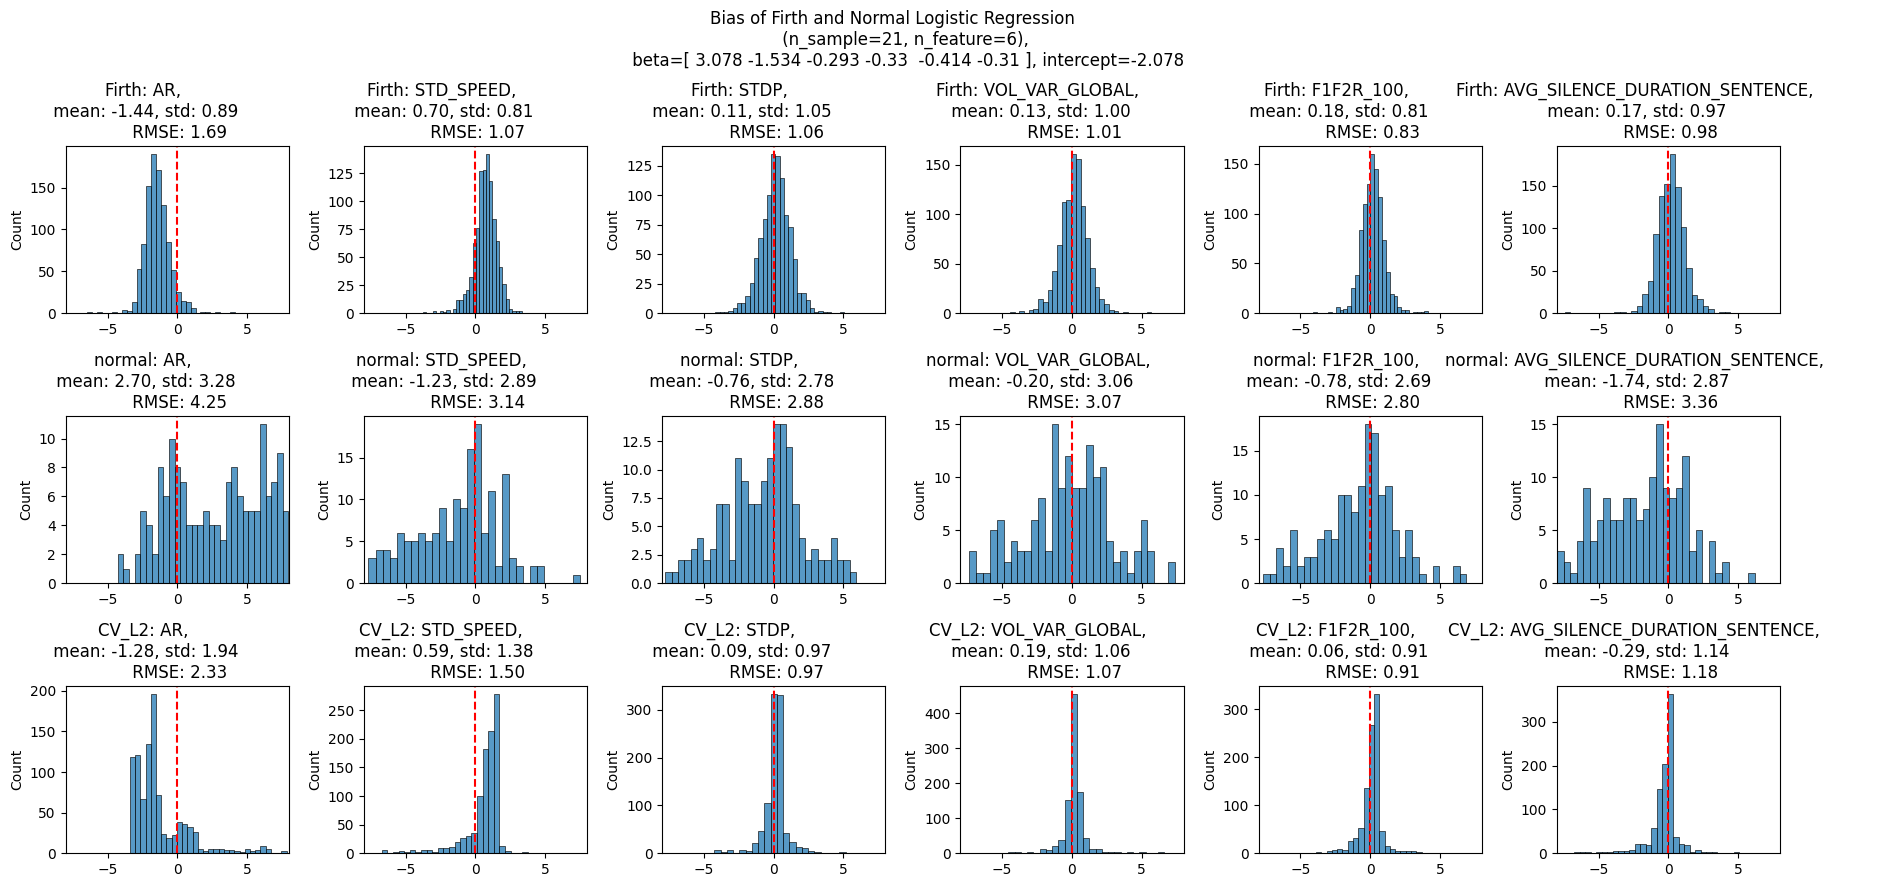

In [12]:
# without outliers
fig, axs = plt.subplots(
    len(method2coefs), n_feature, figsize=(3 * n_feature, 3 * len(method2coefs))
)
for i, method in enumerate(method2coefs.keys()):
    bias = method2coefs[method] - beta
    thresh = 8
    bias = bias[~np.any(np.abs(bias) > thresh, axis=1)]
    xlim = (-thresh, thresh)
    for j in range(n_feature):
        sns.histplot(bias[:, j], ax=axs[i, j], bins=30)
        axs[i, j].set_title(
            f"{method}: {feature_cols[j]}, \
            \n mean: {bias[:, j].mean():.2f}, std: {bias[:, j].std():.2f} \
            \n RMSE: {np.sqrt((bias[:, j] ** 2).mean()):.2f}"
        )
        axs[i, j].axvline(0, color="r", linestyle="--")
        axs[i, j].set_xlim(xlim)
fig.suptitle(
    f"Bias of Firth and Normal Logistic Regression \n \
    (n_sample={n_sample}, n_feature={n_feature}), \n \
    beta={np.round(beta, 3)}, intercept={np.round(intercept, 3)}"
)
plt.tight_layout()